In [39]:
!pip install gym


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from google.colab import widgets
import time

# Deterministic Environment

In [3]:
class DeterministicEnv(gym.Env):
  metadata = {'render.modes':[]}
  def __init__(self):
    self.table_dim = 6
    self.observation_space = spaces.Discrete(self.table_dim*self.table_dim)
    self.action_space = spaces.Discrete(4)
    self.maxtimesteps=40
    self.rewardStates = dict()

    for i in range(self.table_dim):
      for j in range(self.table_dim):
        self.rewardStates[(i,j)] = -1
      
    self.rewardStates[(2,2)] = -3
    self.rewardStates[(1,4)] = -4
    self.rewardStates[(self.table_dim-1,self.table_dim-1)] = 100


  def reset(self):
    self.timesteps = 0
    self.agent_pos = [0,0]
    self.goal_pos = [self.table_dim-1,self.table_dim-1]
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    return self.agent_pos



  def step(self,action):
    self.state = np.random.choice(self.observation_space.n)

    if action == 0: #down
      self.agent_pos[0] +=1
    elif action==1: #up
      self.agent_pos[0] -=1
    elif action==2:#right
      self.agent_pos[1] += 1
    elif action==3: #left
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos,0,self.table_dim-1)
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    reward = 0
    if tuple(self.agent_pos) in self.rewardStates: #Checking if agent is in reward position
      reward = self.rewardStates[tuple(self.agent_pos)]

    self.timesteps +=1
    done = False
    if (self.timesteps >= self.maxtimesteps) or (tuple(self.agent_pos) == tuple(self.goal_pos)):#Ensuring Safety in AI
      done = True 
    info = {}

    return self.agent_pos, reward, done, info



  def render(self):
    plt.imshow(self.state)

# Stochastic Environment 

In [4]:
class StochasticEnv(gym.Env):
  metadata = {'render.modes':[]}
  def __init__(self):

    self.table_dim = 6
    self.observation_space = spaces.Discrete(self.table_dim*self.table_dim)
    self.action_space = spaces.Discrete(4)
    self.maxtimesteps=40
    self.rewardStates = dict()

    for i in range(self.table_dim):
      for j in range(self.table_dim):
        self.rewardStates[(i,j)] = -1
      
    self.rewardStates[(2,2)] = -3
    self.rewardStates[(1,4)] = -4
    self.rewardStates[(self.table_dim-1,self.table_dim-1)] = 100


  def reset(self):
    self.timesteps = 0
    self.agent_pos = [0,0]
    self.goal_pos = [self.table_dim-1,self.table_dim-1]
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    return self.agent_pos



  def step(self,action):
    self.state = np.random.choice(self.observation_space.n)
    if action == 0: #down
      if random.uniform(0, 1)<0.8: 
        self.agent_pos[0] +=1
    elif action==1: #up   
 #Declared a probability for action up. If it's less than 0.2, it should take left or else stay in its current state
      if random.uniform(0, 1)<0.2: 
        self.agent_pos[0] -=1
    elif action==2: #right
      if random.uniform(0, 1)<0.8: 
        self.agent_pos[1] += 1
    elif action==3: #left
#Declared a probability for action left. If it's less than 0.2, it should take left or else stay in its current state
      if random.uniform(0, 1)<0.2:
        self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos,0,self.table_dim-1)
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    reward = 0
    if tuple(self.agent_pos) in self.rewardStates: #Checking if agent is in reward position
      reward = self.rewardStates[tuple(self.agent_pos)]

    self.timesteps +=1
    done = False
    if (self.timesteps >= self.maxtimesteps) or (tuple(self.agent_pos) == tuple(self.goal_pos)):#Ensuring Safety in AI
      done = True 
    info = {}

    return self.agent_pos, reward, done, info




  def render(self):
    plt.imshow(self.state)

# Q-Learning Agent

In [41]:
class QlearningAgent:
    def __init__(self, env,epsilon=1.0,lr=0.6,gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.table_dim

        self.q_table = np.zeros((q_table_dim,q_table_dim,env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
    
    def policy(self,observation):

      if random.uniform(0,1)<self.epsilon:
        return np.random.choice(self.action_space.n)
      else:
        return np.argmax(self.q_table[int(observation[0]),int(observation[1])])
     
    def step(self, observation):
        return self.policy(observation)
    
    def update(self,state,action,reward,next_state):
      # print(np.max(self.q_table[next_state]))

      if next_state is None:
        print("Possible")
      
      old_q = self.q_table[state[0]][state[1]][action]

      temp_diff = reward + (self.gamma*(np.max(self.q_table[next_state[0],next_state[1]]))) - old_q
      new_q = old_q + self.lr*temp_diff

      self.q_table[state[0]][state[1]][action] = new_q

    
    def setEpsilon(self,epsilon):
      self.epsilon = epsilon

# Q-Learning Deterministic Env


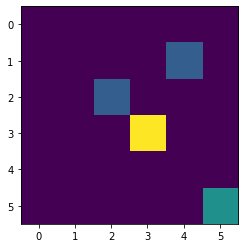

Episode 0
Epsilon 0.13533526065815754
***************************************************


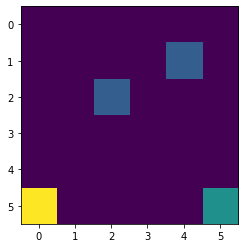

Episode 100
Epsilon 0.13533526065815754
***************************************************


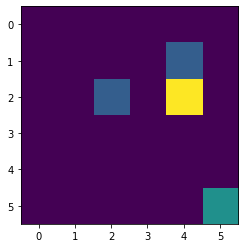

Episode 200
Epsilon 0.13533526065815754
***************************************************


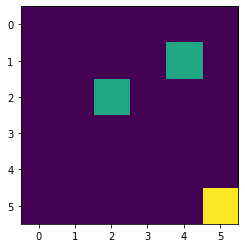

Episode 300
Epsilon 0.13533526065815754
***************************************************


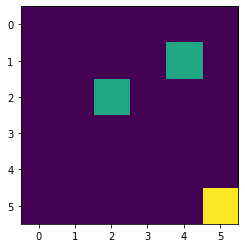

Episode 400
Epsilon 0.13533526065815754
***************************************************


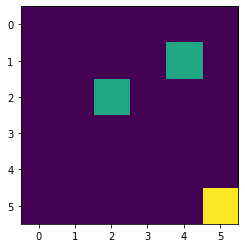

Episode 500
Epsilon 0.13533526065815754
***************************************************


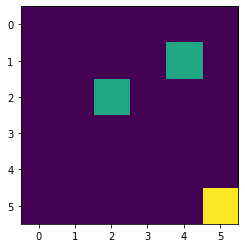

Episode 600
Epsilon 0.13533526065815754
***************************************************


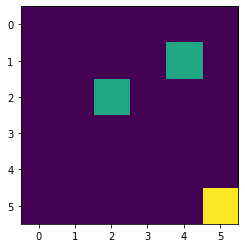

Episode 700
Epsilon 0.13533526065815754
***************************************************


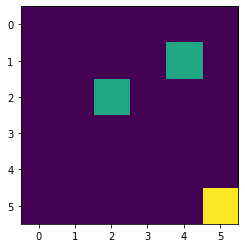

Episode 800
Epsilon 0.13533526065815754
***************************************************


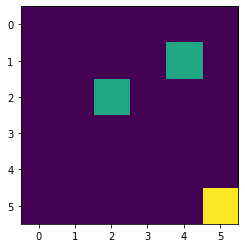

Episode 900
Epsilon 0.13533526065815754
***************************************************


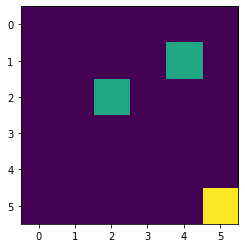

Episode 1000
Epsilon 0.13533526065815754
***************************************************


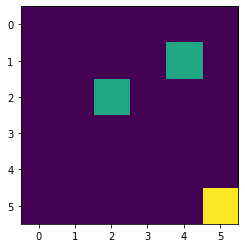

Episode 1100
Epsilon 0.13533526065815754
***************************************************


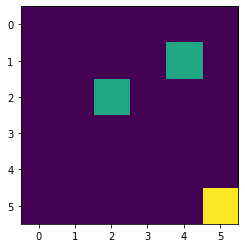

Episode 1200
Epsilon 0.13533526065815754
***************************************************


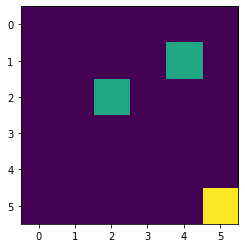

Episode 1300
Epsilon 0.13533526065815754
***************************************************


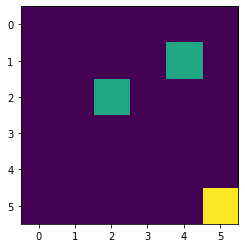

Episode 1400
Epsilon 0.13533526065815754
***************************************************


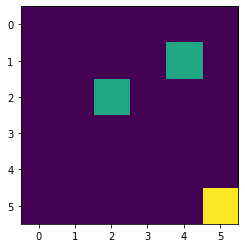

Episode 1500
Epsilon 0.13533526065815754
***************************************************


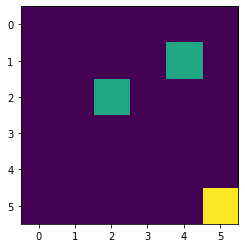

Episode 1600
Epsilon 0.13533526065815754
***************************************************


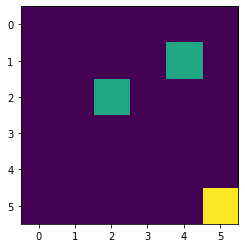

Episode 1700
Epsilon 0.13533526065815754
***************************************************


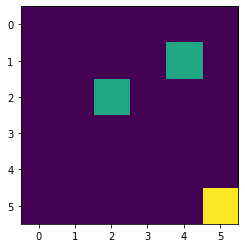

Episode 1800
Epsilon 0.13533526065815754
***************************************************


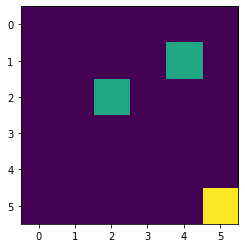

Episode 1900
Epsilon 0.13533526065815754
***************************************************


In [42]:
# setting up environment and agent
env = DeterministicEnv()
agent = QlearningAgent(env)
episodes = 2000
min_epsilon = 0.1

q_d_epsilons = []
q_d_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False
  q_d_epsilons.append(agent.epsilon)

  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    agent.update(state,action,reward,next_state)

  q_d_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.999)
  agent.setEpsilon(epsilon)
  if not episode%100:
         env.render()
         plt.show()
         print('Episode {}'.format(episode))
         print('Epsilon {}'.format(epsilons[-1]))
         
         print('***************************************************')



Testing Q-Learning Deterministic

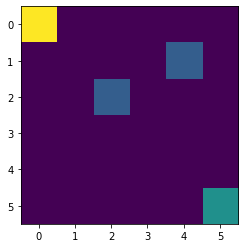

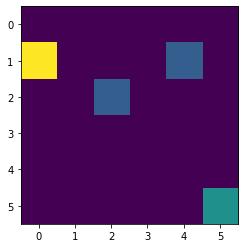

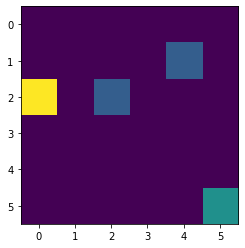

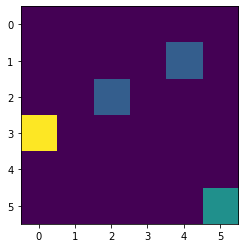

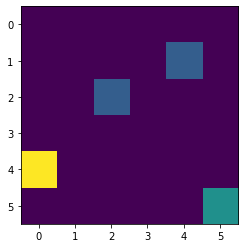

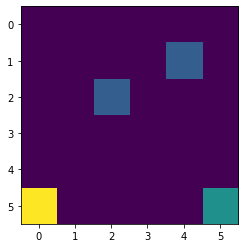

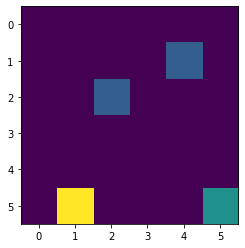

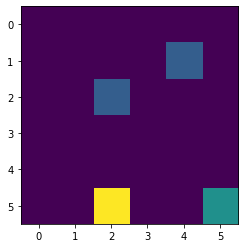

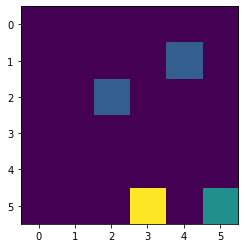

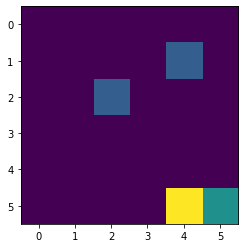

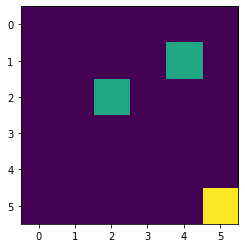

In [43]:
env = DeterministicEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

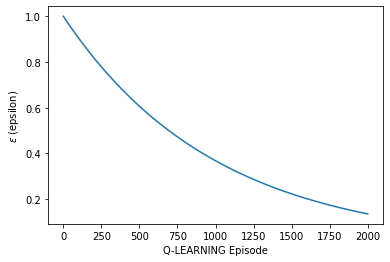

In [44]:
plt.xlabel('Q-LEARNING Episode')
plt.ylabel('$\epsilon$ (epsilon)')
plt.plot(q_d_epsilons)

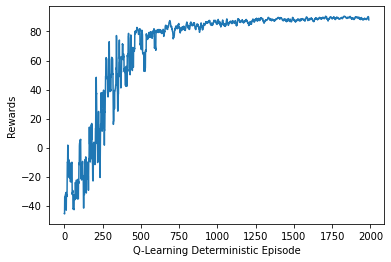

In [45]:
window = 10
plt.xlabel('Q-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])

# **Q-Learning Stochastic Environment**

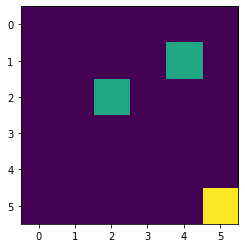

Episode 0
Epsilon 0.13533526065815754
***************************************************


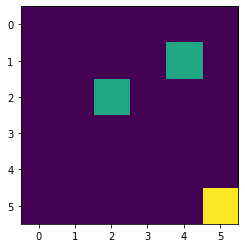

Episode 100
Epsilon 0.13533526065815754
***************************************************


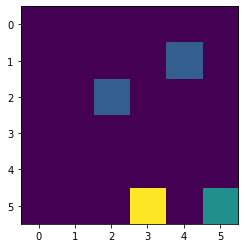

Episode 200
Epsilon 0.13533526065815754
***************************************************


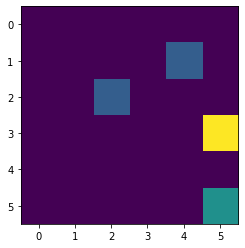

Episode 300
Epsilon 0.13533526065815754
***************************************************


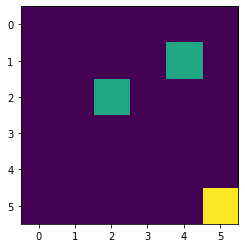

Episode 400
Epsilon 0.13533526065815754
***************************************************


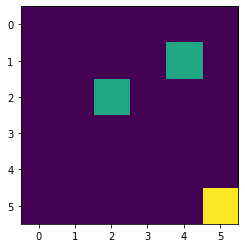

Episode 500
Epsilon 0.13533526065815754
***************************************************


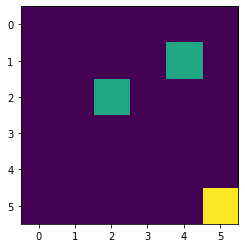

Episode 600
Epsilon 0.13533526065815754
***************************************************


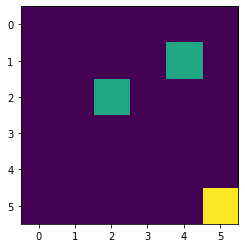

Episode 700
Epsilon 0.13533526065815754
***************************************************


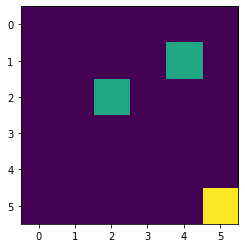

Episode 800
Epsilon 0.13533526065815754
***************************************************


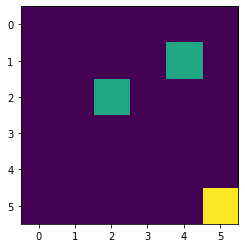

Episode 900
Epsilon 0.13533526065815754
***************************************************


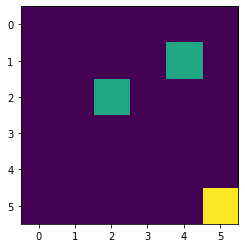

Episode 1000
Epsilon 0.13533526065815754
***************************************************


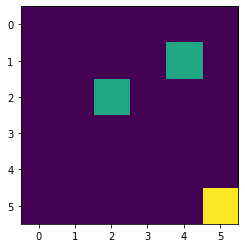

Episode 1100
Epsilon 0.13533526065815754
***************************************************


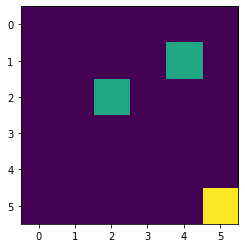

Episode 1200
Epsilon 0.13533526065815754
***************************************************


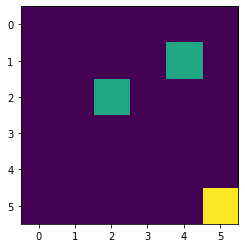

Episode 1300
Epsilon 0.13533526065815754
***************************************************


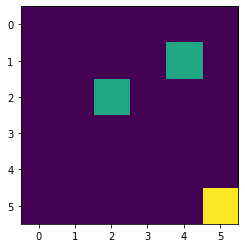

Episode 1400
Epsilon 0.13533526065815754
***************************************************


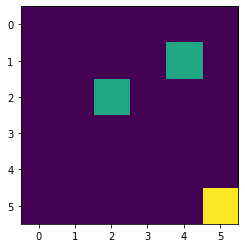

Episode 1500
Epsilon 0.13533526065815754
***************************************************


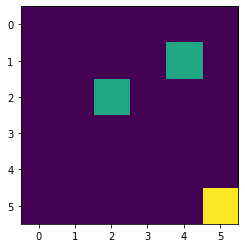

Episode 1600
Epsilon 0.13533526065815754
***************************************************


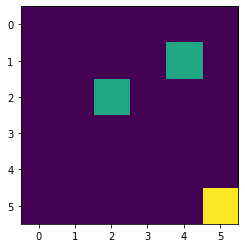

Episode 1700
Epsilon 0.13533526065815754
***************************************************


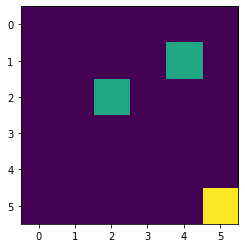

Episode 1800
Epsilon 0.13533526065815754
***************************************************


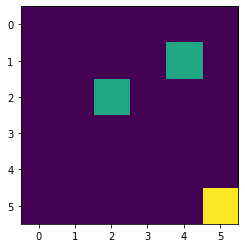

Episode 1900
Epsilon 0.13533526065815754
***************************************************


In [46]:
# setting up environment and agent
env = StochasticEnv()
agent = QlearningAgent(env)
episodes = 2000
min_epsilon = 0.1

q_s_epsilons = []
q_s_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False
  q_s_epsilons.append(agent.epsilon)

  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    agent.update(state,action,reward,next_state)

  q_s_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.999)
  agent.setEpsilon(epsilon)
  if not episode%100:
         env.render()
         plt.show()
         print('Episode {}'.format(episode))
         print('Epsilon {}'.format(epsilons[-1]))
         
         print('***************************************************')

Testing Q-Learning Stochastic

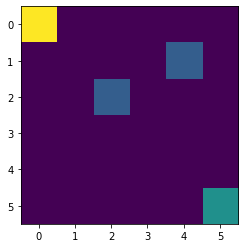

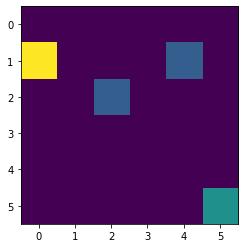

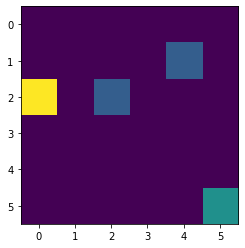

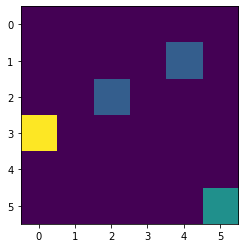

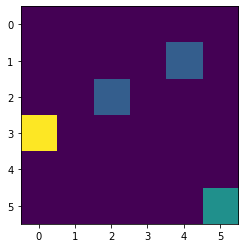

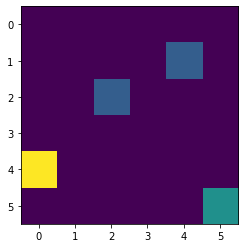

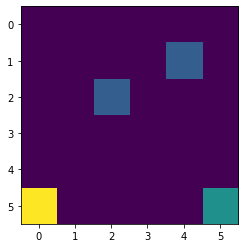

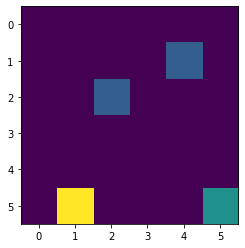

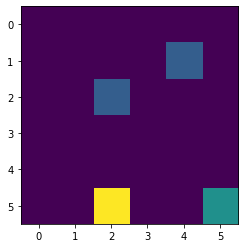

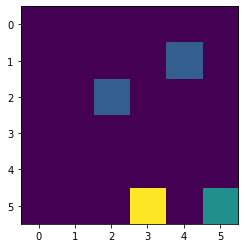

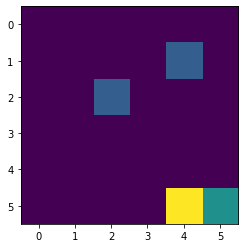

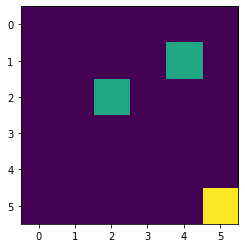

In [47]:
env = StochasticEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

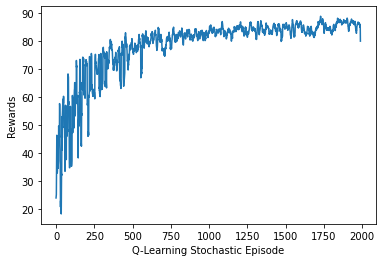

In [48]:
window = 10
plt.xlabel('Q-Learning Stochastic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_s_rewards[tr:tr+window]) for tr in range(window, len(q_s_rewards))])

# TD(0) Agent

In [27]:
class TDAgent:
    def __init__(self, env,lr=0.6,gamma=0.5):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.v_table_dim = env.table_dim

        self.v_table = np.zeros((self.v_table_dim,self.v_table_dim))

        self.lr = lr
        self.gamma = gamma
    
    def policy(self,observation):

      if random.uniform(0,1)< 0.1:
        return np.random.choice(self.action_space.n)
      else:
        arr=[]
        x,y = observation
        if x>=self.v_table_dim-1:
          arr.append(-100)
        else:
          arr.append(self.v_table[x+1][y])
        
        if x<=0:
          arr.append(-100)
        else:
          arr.append(self.v_table[x-1][y])

        if y>=self.v_table_dim-1:
          arr.append(-100)
        else:
          arr.append(self.v_table[x][y+1])
        
        if y<=0:
          arr.append(-100)
        else:
          arr.append(self.v_table[x][y-1])


        return np.argmax(arr)
     
    def step(self, observation):
        return self.policy(observation)
    
    def update(self,state,reward,next_state):
      # print(np.max(self.q_table[next_state]))

      old_v = self.v_table[state[0],state[1]]

      temp_diff = reward + (self.gamma*self.v_table[next_state[0],next_state[1]]) - old_v

      new_v = old_v + self.lr*temp_diff
      self.v_table[state[0],state[1]] = new_v

# Testing TD(0) Deterministic

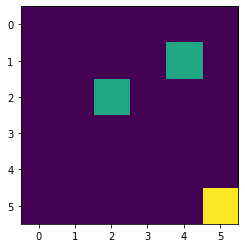

Episode 0
***************************************************


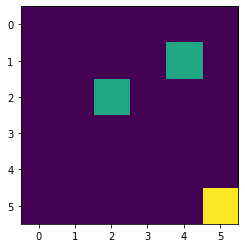

Episode 100
***************************************************


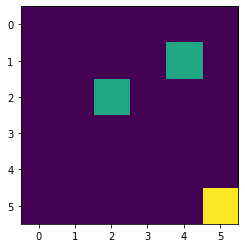

Episode 200
***************************************************


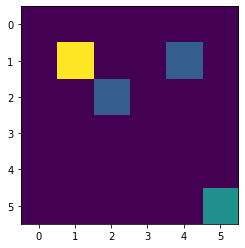

Episode 300
***************************************************


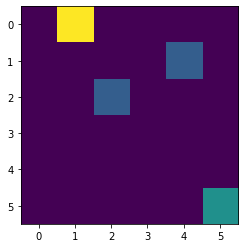

Episode 400
***************************************************


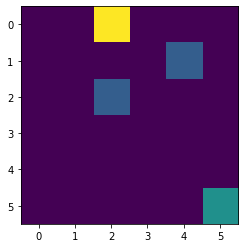

Episode 500
***************************************************


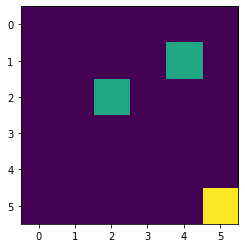

Episode 600
***************************************************


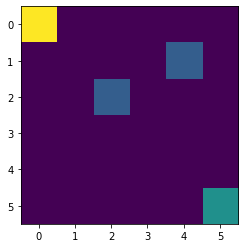

Episode 700
***************************************************


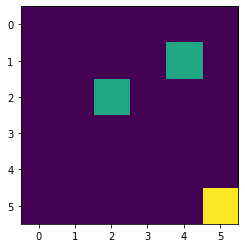

Episode 800
***************************************************


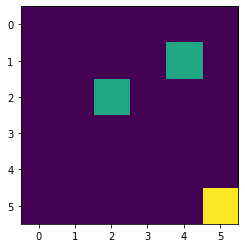

Episode 900
***************************************************


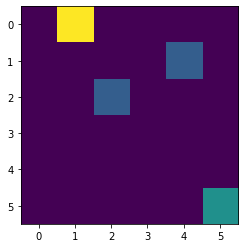

Episode 1000
***************************************************


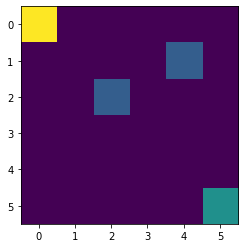

Episode 1100
***************************************************


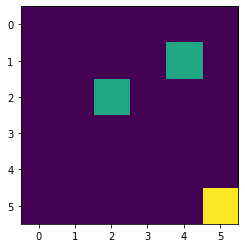

Episode 1200
***************************************************


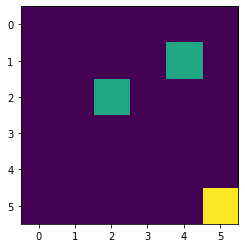

Episode 1300
***************************************************


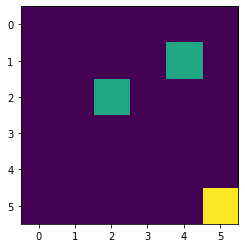

Episode 1400
***************************************************


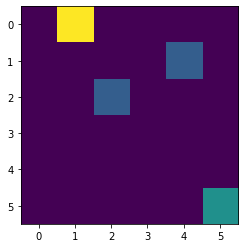

Episode 1500
***************************************************


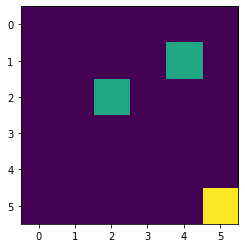

Episode 1600
***************************************************


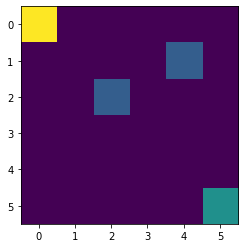

Episode 1700
***************************************************


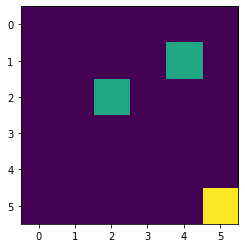

Episode 1800
***************************************************


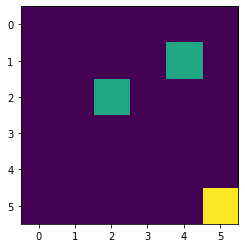

Episode 1900
***************************************************


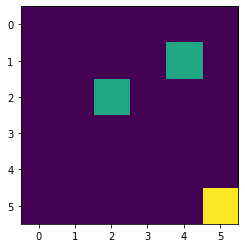

Episode 2000
***************************************************


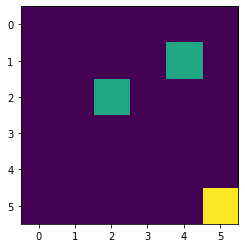

Episode 2100
***************************************************


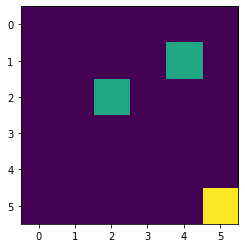

Episode 2200
***************************************************


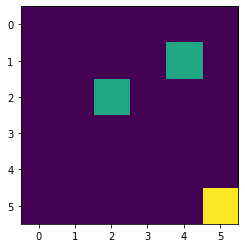

Episode 2300
***************************************************


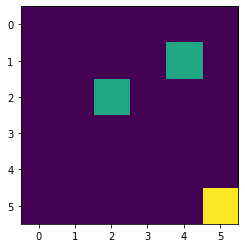

Episode 2400
***************************************************


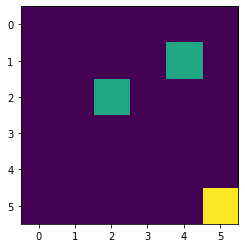

Episode 2500
***************************************************


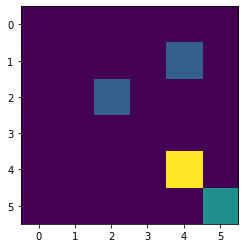

Episode 2600
***************************************************


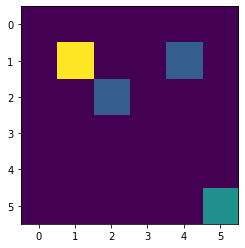

Episode 2700
***************************************************


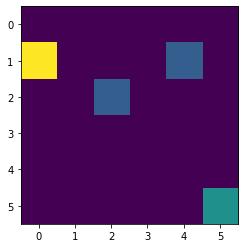

Episode 2800
***************************************************


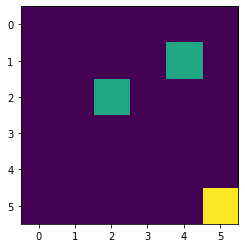

Episode 2900
***************************************************


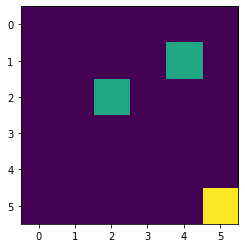

Episode 3000
***************************************************


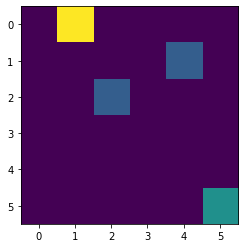

Episode 3100
***************************************************


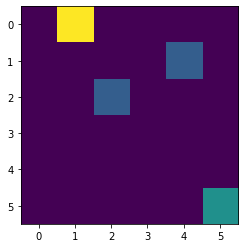

Episode 3200
***************************************************


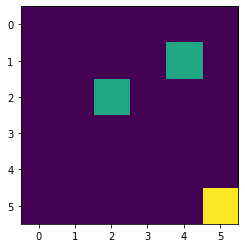

Episode 3300
***************************************************


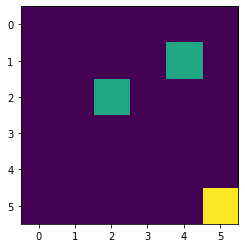

Episode 3400
***************************************************


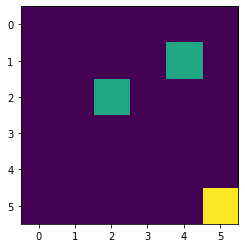

Episode 3500
***************************************************


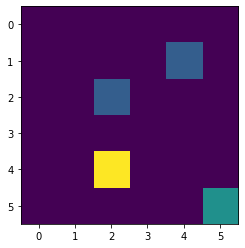

Episode 3600
***************************************************


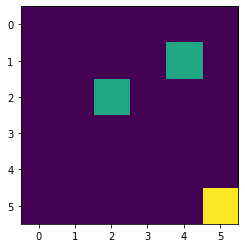

Episode 3700
***************************************************


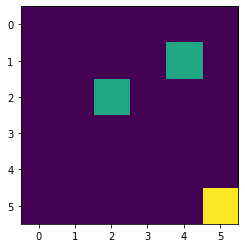

Episode 3800
***************************************************


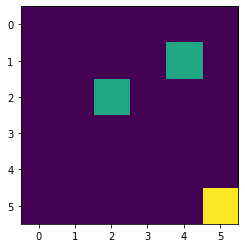

Episode 3900
***************************************************


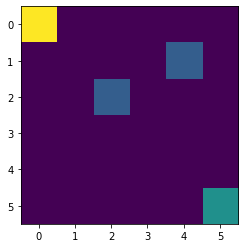

Episode 4000
***************************************************


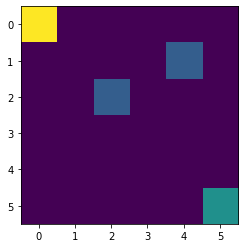

Episode 4100
***************************************************


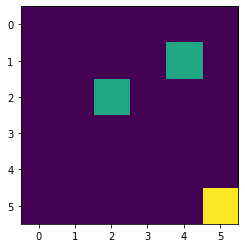

Episode 4200
***************************************************


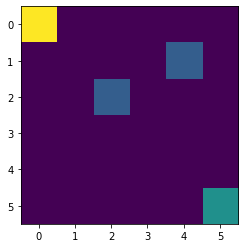

Episode 4300
***************************************************


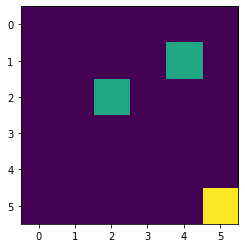

Episode 4400
***************************************************


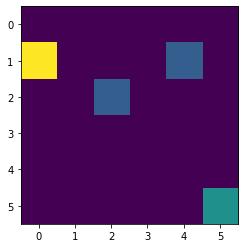

Episode 4500
***************************************************


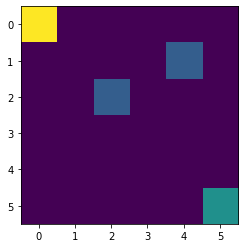

Episode 4600
***************************************************


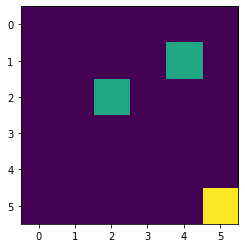

Episode 4700
***************************************************


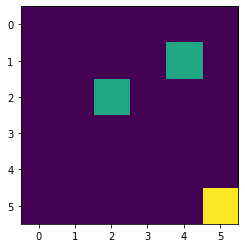

Episode 4800
***************************************************


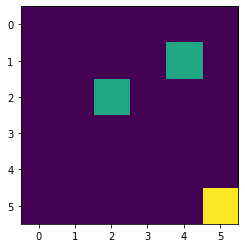

Episode 4900
***************************************************


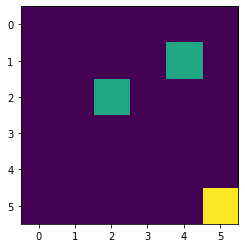

Episode 5000
***************************************************


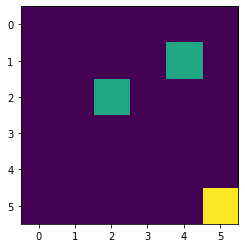

Episode 5100
***************************************************


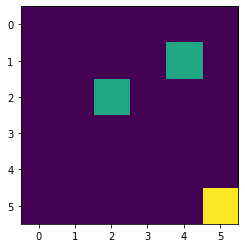

Episode 5200
***************************************************


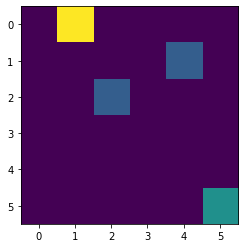

Episode 5300
***************************************************


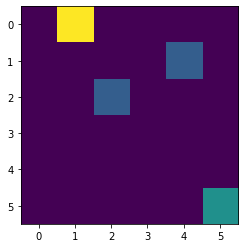

Episode 5400
***************************************************


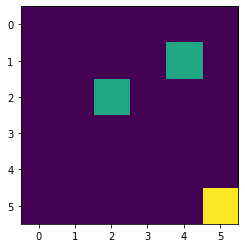

Episode 5500
***************************************************


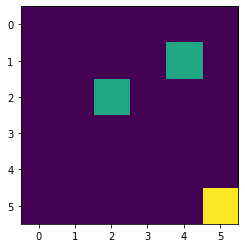

Episode 5600
***************************************************


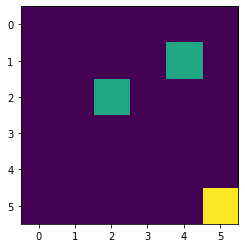

Episode 5700
***************************************************


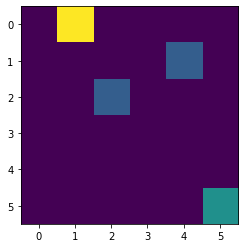

Episode 5800
***************************************************


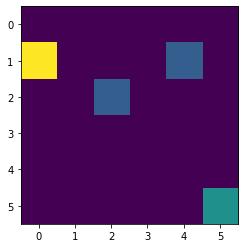

Episode 5900
***************************************************


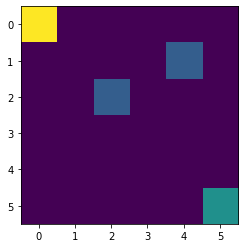

Episode 6000
***************************************************


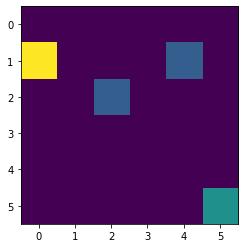

Episode 6100
***************************************************


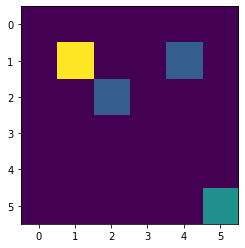

Episode 6200
***************************************************


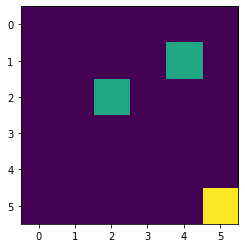

Episode 6300
***************************************************


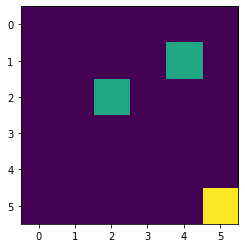

Episode 6400
***************************************************


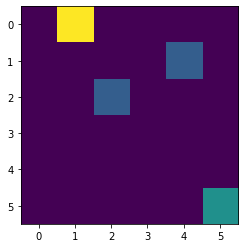

Episode 6500
***************************************************


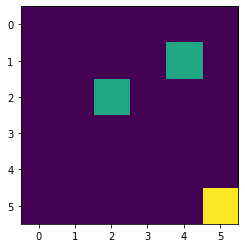

Episode 6600
***************************************************


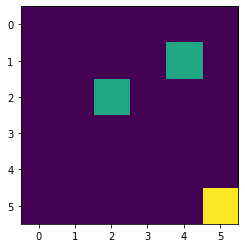

Episode 6700
***************************************************


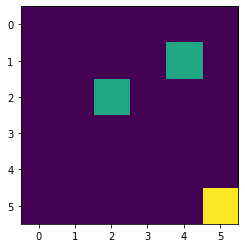

Episode 6800
***************************************************


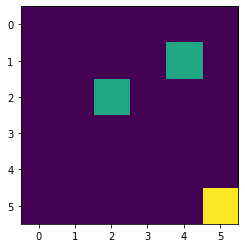

Episode 6900
***************************************************


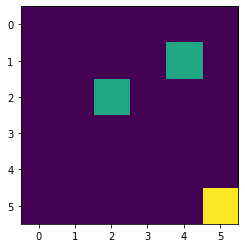

Episode 7000
***************************************************


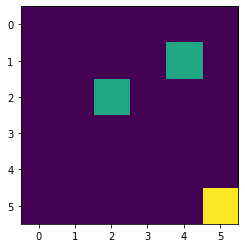

Episode 7100
***************************************************


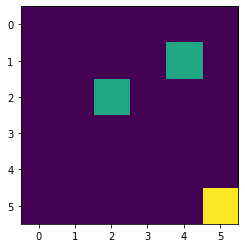

Episode 7200
***************************************************


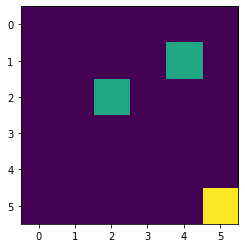

Episode 7300
***************************************************


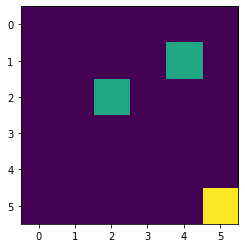

Episode 7400
***************************************************


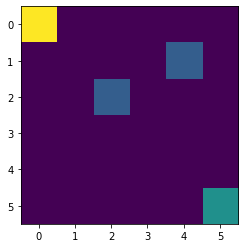

Episode 7500
***************************************************


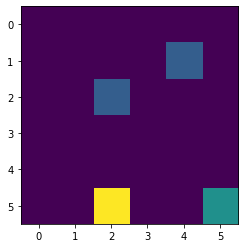

Episode 7600
***************************************************


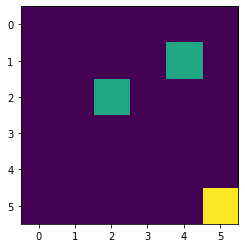

Episode 7700
***************************************************


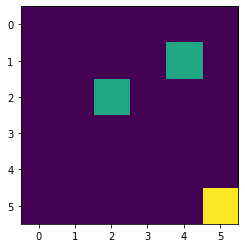

Episode 7800
***************************************************


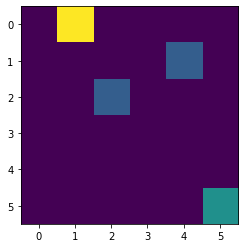

Episode 7900
***************************************************


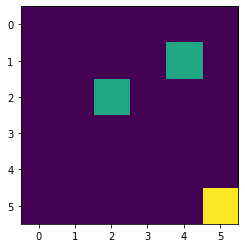

Episode 8000
***************************************************


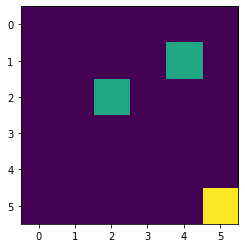

Episode 8100
***************************************************


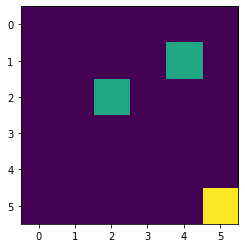

Episode 8200
***************************************************


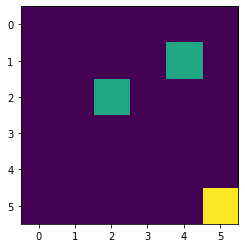

Episode 8300
***************************************************


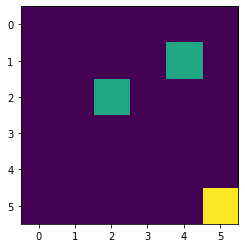

Episode 8400
***************************************************


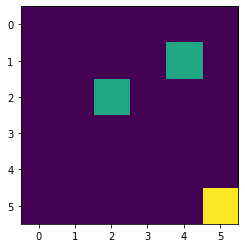

Episode 8500
***************************************************


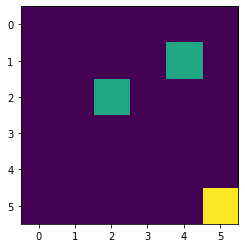

Episode 8600
***************************************************


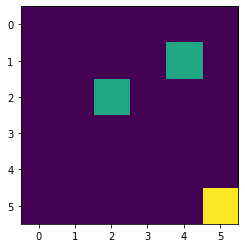

Episode 8700
***************************************************


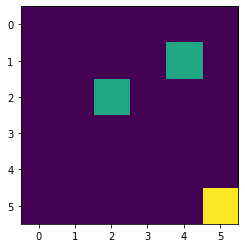

Episode 8800
***************************************************


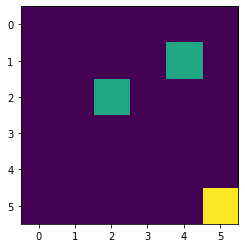

Episode 8900
***************************************************


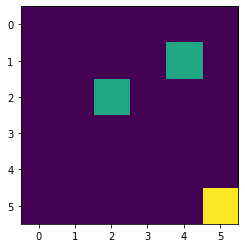

Episode 9000
***************************************************


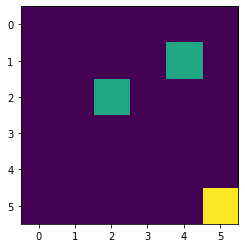

Episode 9100
***************************************************


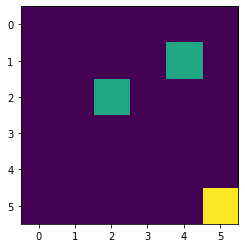

Episode 9200
***************************************************


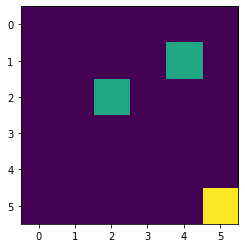

Episode 9300
***************************************************


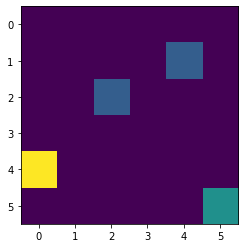

Episode 9400
***************************************************


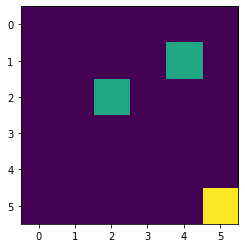

Episode 9500
***************************************************


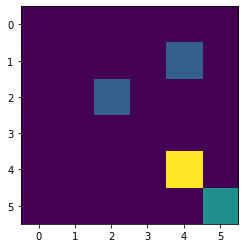

Episode 9600
***************************************************


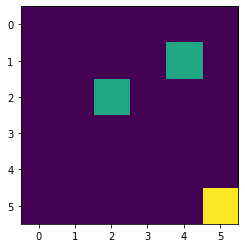

Episode 9700
***************************************************


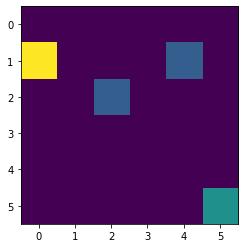

Episode 9800
***************************************************


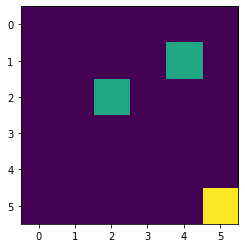

Episode 9900
***************************************************


In [49]:
# setting up environment and agent
env = DeterministicEnv()
agent = TDAgent(env)
episodes = 10000


td_d_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False


  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    agent.update(state,reward,next_state)

  td_d_rewards.append(curr_reward)

  if not episode%100:
         env.render()
         plt.show()
         print('Episode {}'.format(episode))    
         print('***************************************************')

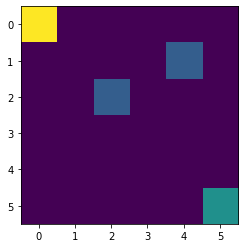

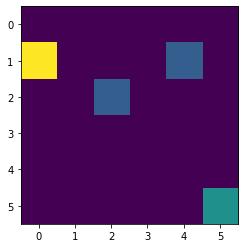

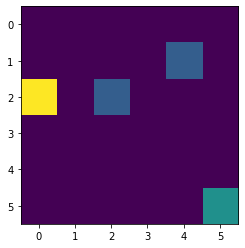

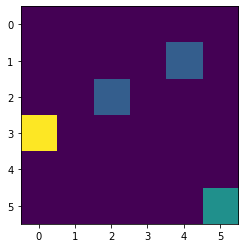

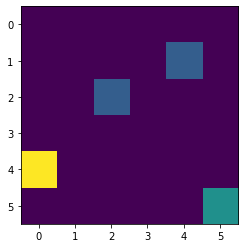

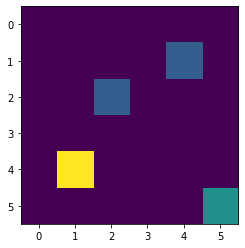

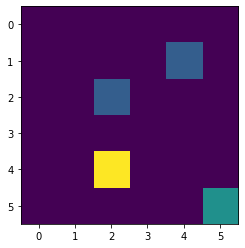

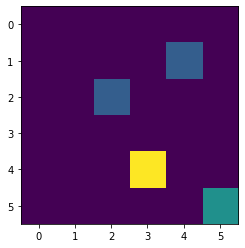

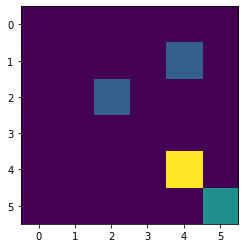

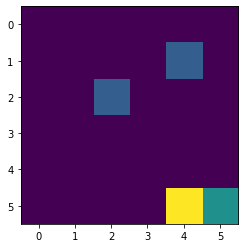

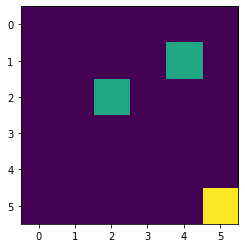

In [50]:
env = DeterministicEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

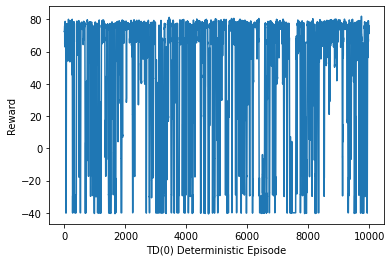

In [51]:
window = 10
plt.xlabel('TD(0) Deterministic Episode')
plt.ylabel('Reward')
plt.plot([np.mean(td_d_rewards[tr:tr+window]) for tr in range(window, len(td_d_rewards))])

# TD(0) Stochastic Environment 

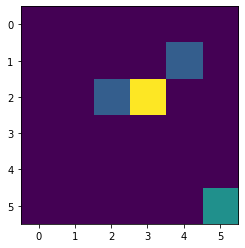

Episode 0
***************************************************


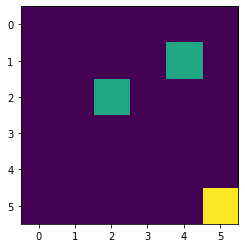

Episode 100
***************************************************


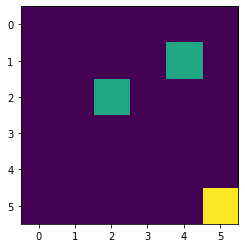

Episode 200
***************************************************


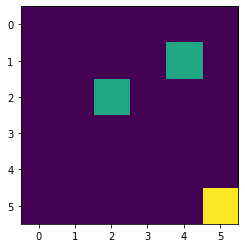

Episode 300
***************************************************


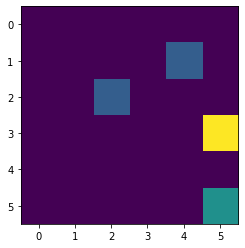

Episode 400
***************************************************


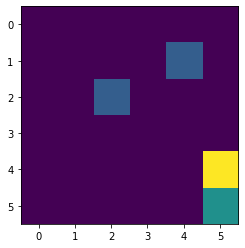

Episode 500
***************************************************


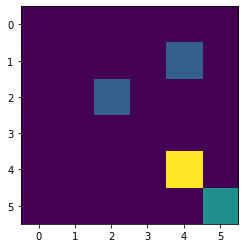

Episode 600
***************************************************


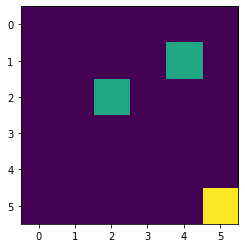

Episode 700
***************************************************


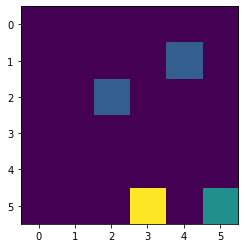

Episode 800
***************************************************


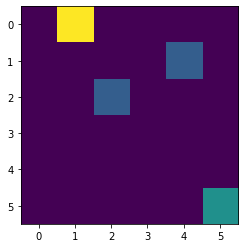

Episode 900
***************************************************


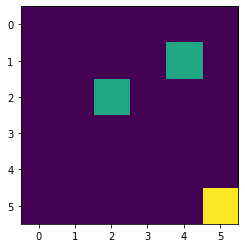

Episode 1000
***************************************************


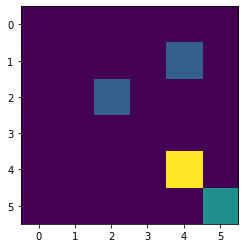

Episode 1100
***************************************************


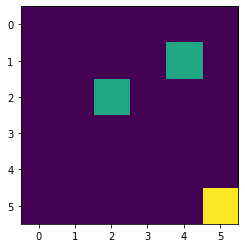

Episode 1200
***************************************************


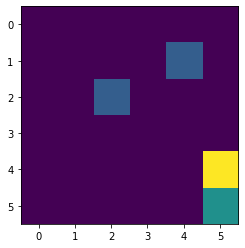

Episode 1300
***************************************************


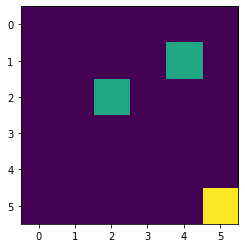

Episode 1400
***************************************************


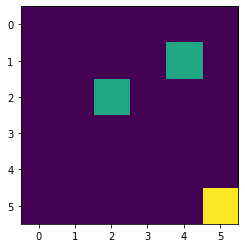

Episode 1500
***************************************************


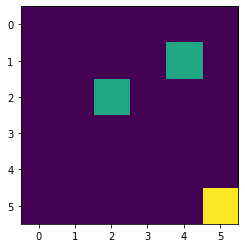

Episode 1600
***************************************************


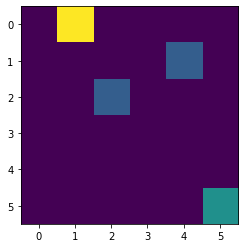

Episode 1700
***************************************************


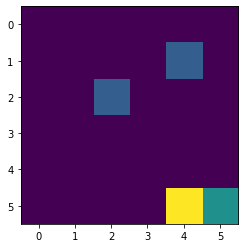

Episode 1800
***************************************************


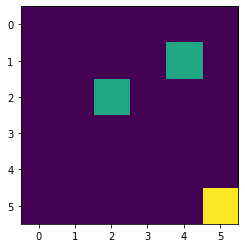

Episode 1900
***************************************************


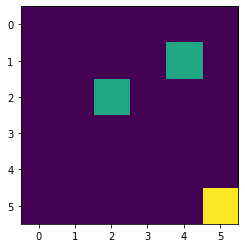

Episode 2000
***************************************************


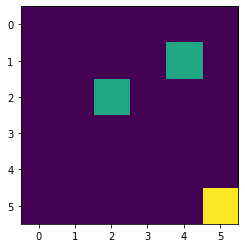

Episode 2100
***************************************************


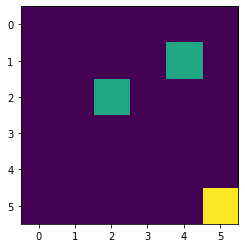

Episode 2200
***************************************************


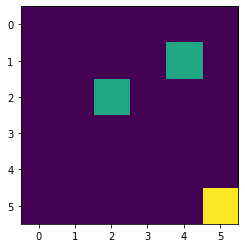

Episode 2300
***************************************************


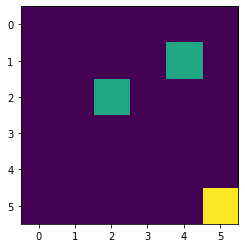

Episode 2400
***************************************************


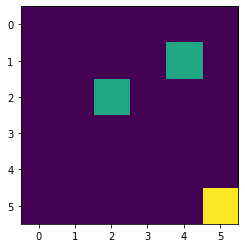

Episode 2500
***************************************************


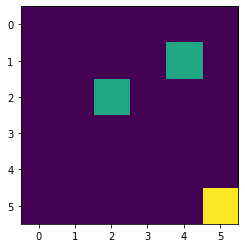

Episode 2600
***************************************************


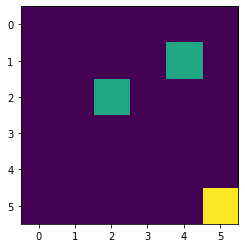

Episode 2700
***************************************************


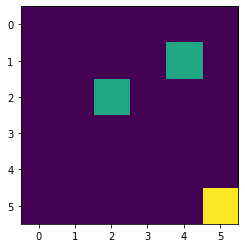

Episode 2800
***************************************************


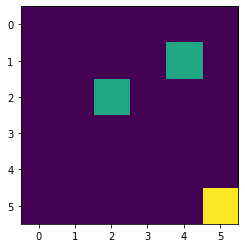

Episode 2900
***************************************************


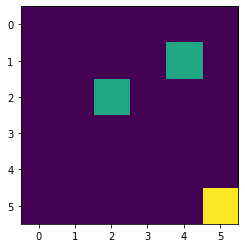

Episode 3000
***************************************************


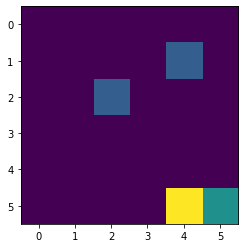

Episode 3100
***************************************************


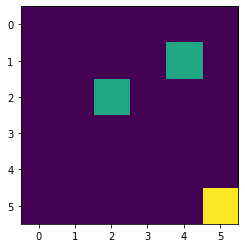

Episode 3200
***************************************************


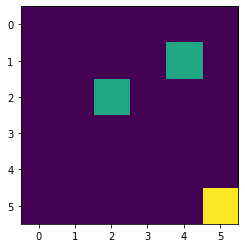

Episode 3300
***************************************************


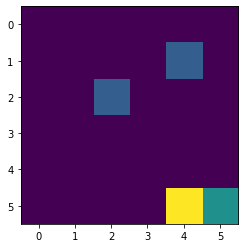

Episode 3400
***************************************************


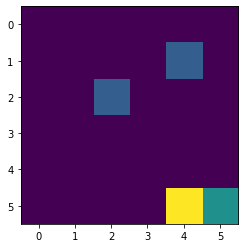

Episode 3500
***************************************************


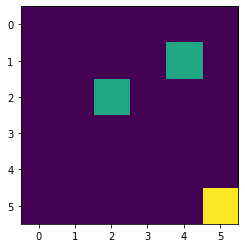

Episode 3600
***************************************************


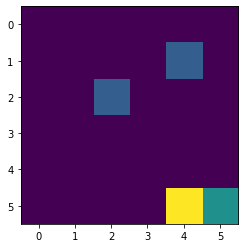

Episode 3700
***************************************************


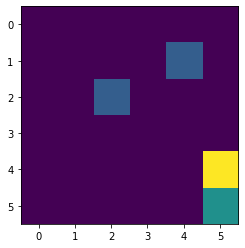

Episode 3800
***************************************************


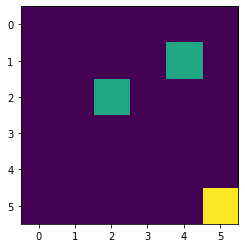

Episode 3900
***************************************************


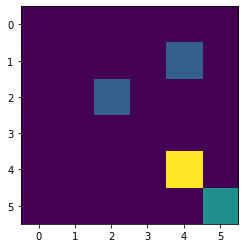

Episode 4000
***************************************************


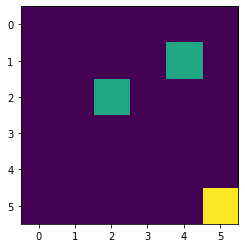

Episode 4100
***************************************************


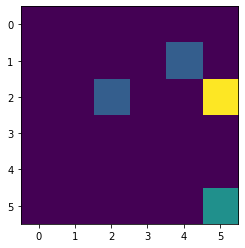

Episode 4200
***************************************************


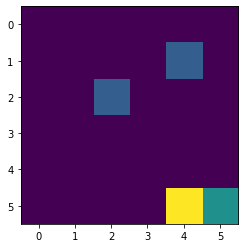

Episode 4300
***************************************************


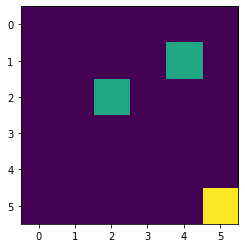

Episode 4400
***************************************************


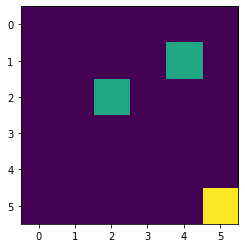

Episode 4500
***************************************************


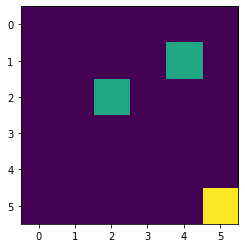

Episode 4600
***************************************************


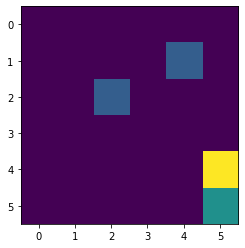

Episode 4700
***************************************************


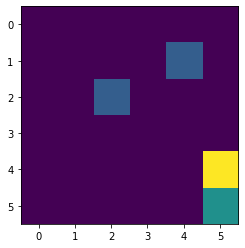

Episode 4800
***************************************************


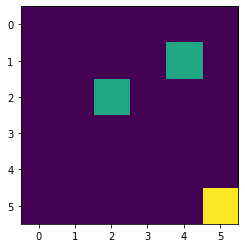

Episode 4900
***************************************************


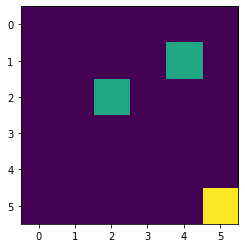

Episode 5000
***************************************************


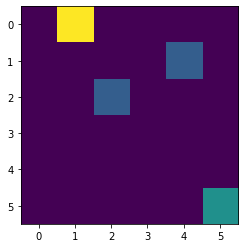

Episode 5100
***************************************************


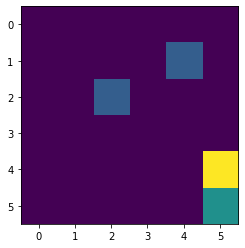

Episode 5200
***************************************************


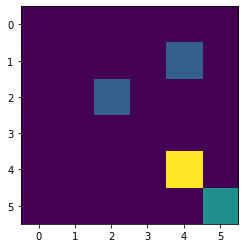

Episode 5300
***************************************************


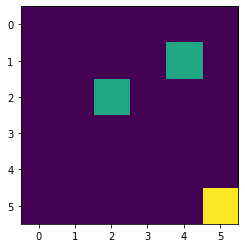

Episode 5400
***************************************************


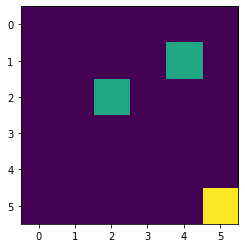

Episode 5500
***************************************************


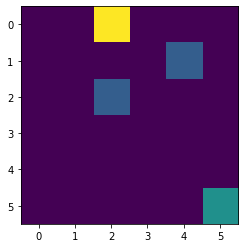

Episode 5600
***************************************************


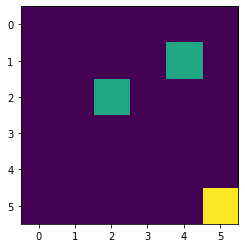

Episode 5700
***************************************************


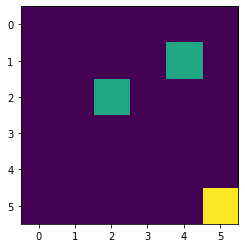

Episode 5800
***************************************************


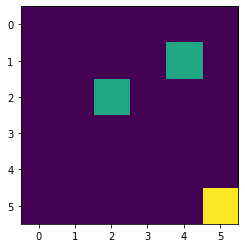

Episode 5900
***************************************************


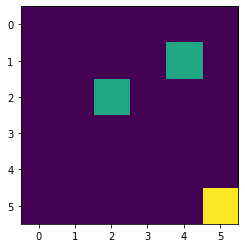

Episode 6000
***************************************************


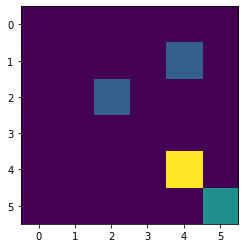

Episode 6100
***************************************************


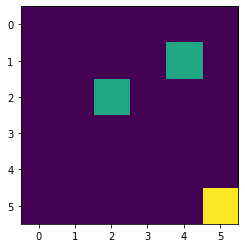

Episode 6200
***************************************************


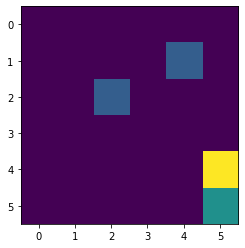

Episode 6300
***************************************************


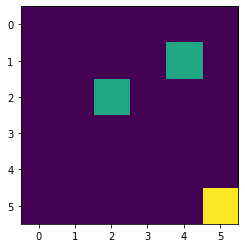

Episode 6400
***************************************************


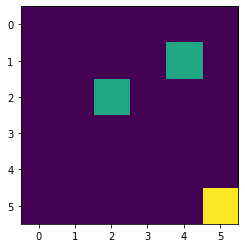

Episode 6500
***************************************************


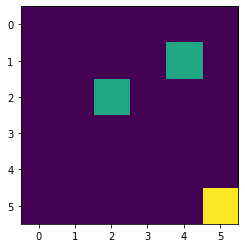

Episode 6600
***************************************************


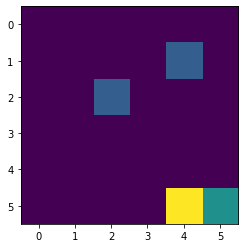

Episode 6700
***************************************************


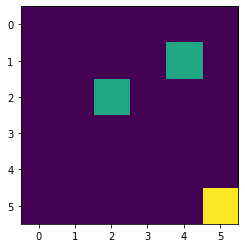

Episode 6800
***************************************************


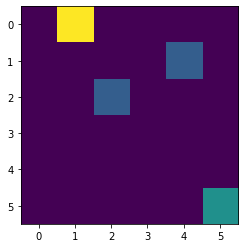

Episode 6900
***************************************************


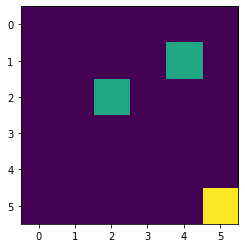

Episode 7000
***************************************************


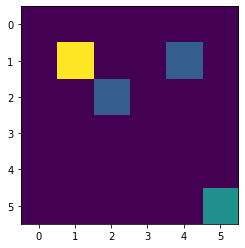

Episode 7100
***************************************************


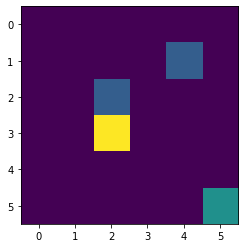

Episode 7200
***************************************************


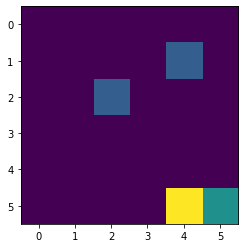

Episode 7300
***************************************************


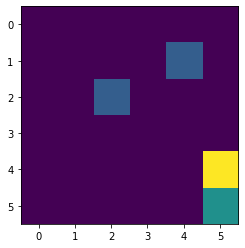

Episode 7400
***************************************************


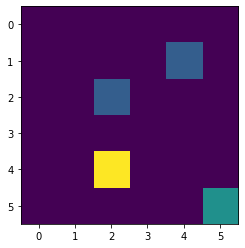

Episode 7500
***************************************************


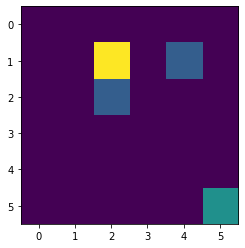

Episode 7600
***************************************************


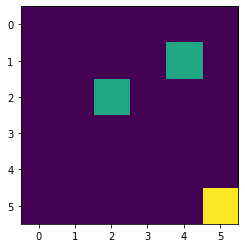

Episode 7700
***************************************************


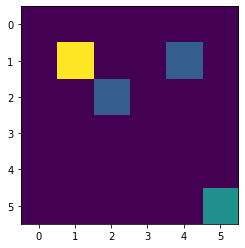

Episode 7800
***************************************************


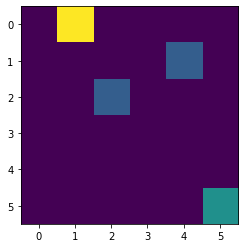

Episode 7900
***************************************************


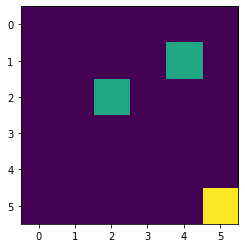

Episode 8000
***************************************************


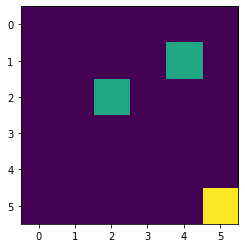

Episode 8100
***************************************************


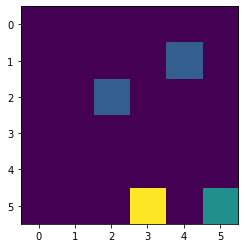

Episode 8200
***************************************************


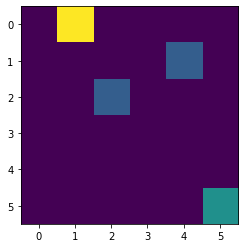

Episode 8300
***************************************************


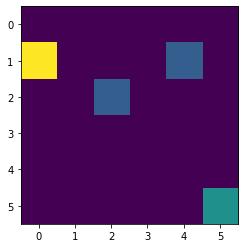

Episode 8400
***************************************************


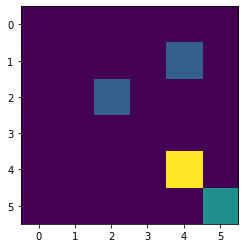

Episode 8500
***************************************************


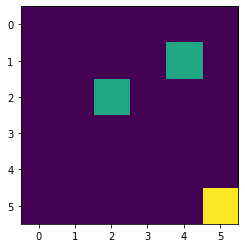

Episode 8600
***************************************************


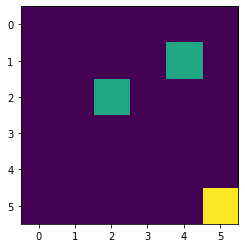

Episode 8700
***************************************************


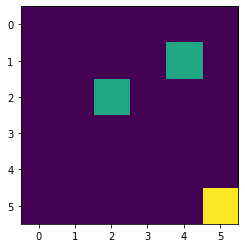

Episode 8800
***************************************************


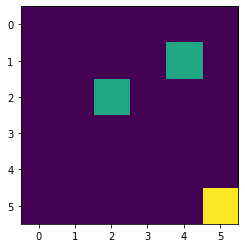

Episode 8900
***************************************************


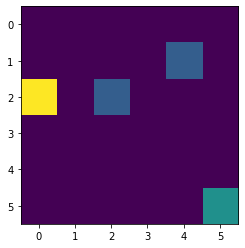

Episode 9000
***************************************************


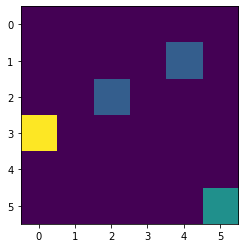

Episode 9100
***************************************************


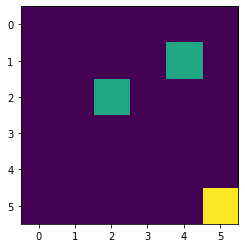

Episode 9200
***************************************************


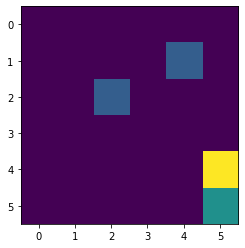

Episode 9300
***************************************************


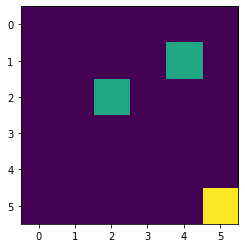

Episode 9400
***************************************************


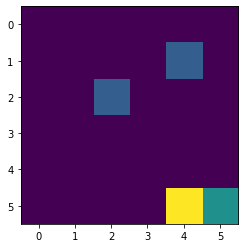

Episode 9500
***************************************************


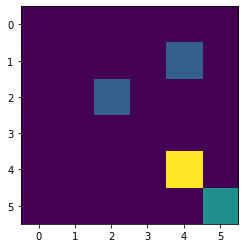

Episode 9600
***************************************************


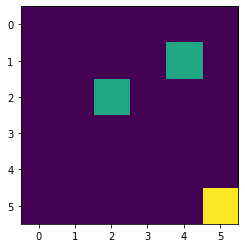

Episode 9700
***************************************************


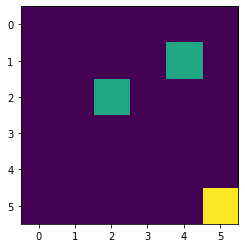

Episode 9800
***************************************************


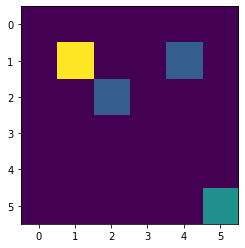

Episode 9900
***************************************************


In [52]:
# setting up environment and agent
env = StochasticEnv()
agent = TDAgent(env)
episodes = 10000


td_s_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False


  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    agent.update(state,reward,next_state)

  td_s_rewards.append(curr_reward)

  if not episode%100:
         env.render()
         plt.show()
         print('Episode {}'.format(episode))    
         print('***************************************************')

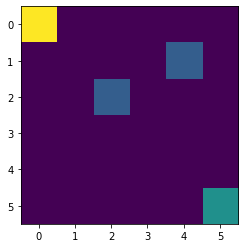

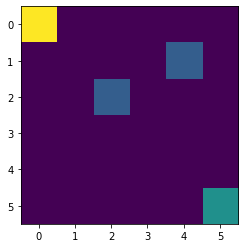

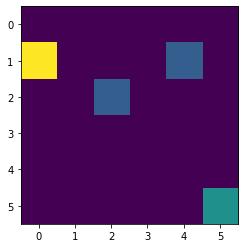

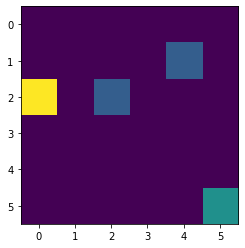

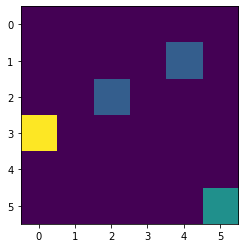

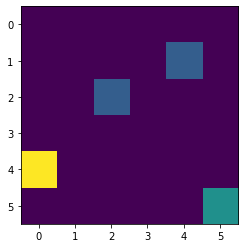

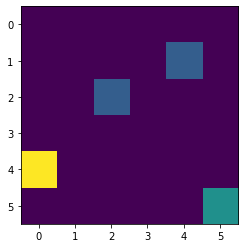

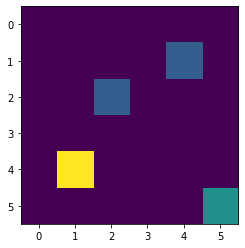

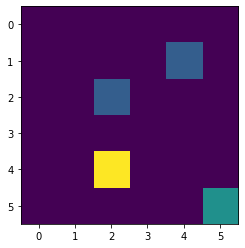

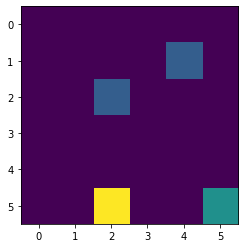

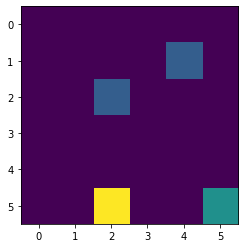

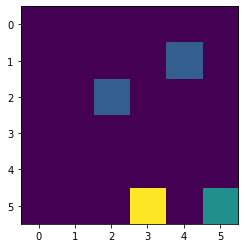

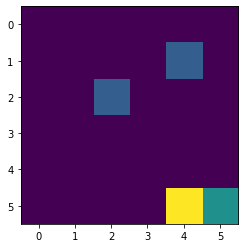

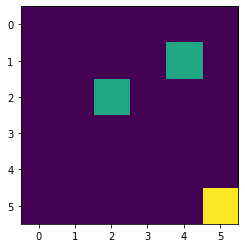

In [53]:
env = StochasticEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

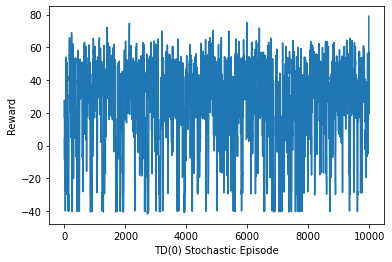

In [54]:

window = 10
plt.xlabel('TD(0) Stochastic Episode')
plt.ylabel('Reward')
plt.plot([np.mean(td_s_rewards[tr:tr+window]) for tr in range(window, len(td_s_rewards))])

# Results


In [57]:
print(q_d_rewards)
print(td_d_rewards)

[-46, -40, -40, -40, -40, -42, -46, -42, -42, -40, -43, -42, -40, -44, -46, -49, -44, -52, -47, -47, -46, 74, -40, -40, -42, -44, -43, -44, -40, -46, -44, -48, 69, -40, -45, -50, -49, 81, 71, -44, -47, 71, -44, -42, -40, -42, -44, -40, 79, 55, -42, -47, -44, -44, 62, -40, -47, -42, -45, 53, 80, -54, -40, -50, -50, 84, -40, -42, -42, -45, -44, -40, -40, -47, -40, -43, -40, -40, -40, -49, -42, -42, -45, 57, -52, -49, -44, -50, -43, -42, 68, -40, -56, -42, -48, -42, -46, 67, -46, -46, -42, -49, -42, -42, -66, -40, 87, -44, -58, -48, -51, 71, -54, -44, 75, -48, 84, 84, -40, -44, -40, 67, -42, -42, 72, -42, -42, -57, -44, 59, -44, -40, -43, 62, 71, -40, -40, -40, -40, -40, -46, -40, -40, -42, -46, -43, 70, -50, -44, -42, -46, 71, 81, -40, -40, -42, -40, -42, 75, -48, -42, -42, -52, 74, -42, -40, 58, -40, -40, -42, -42, -40, -40, 70, -40, -40, -40, 82, 56, -42, -48, 61, 82, -45, -43, -42, 63, -45, -40, 75, -44, -40, 85, -40, 68, 76, -40, 66, -40, -55, -49, -52, -40, -40, -42, 67, -45, 83, 81

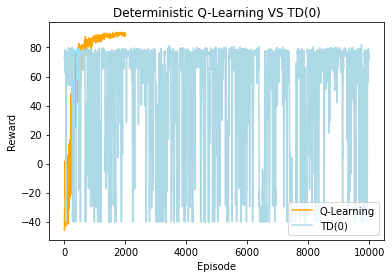

In [74]:

plt.title('Deterministic Q-Learning VS TD(0)')
plt.xlabel('Episode')
plt.ylabel('Reward')
# plt.plot(q_d_rewards,'ro', td_d_rewards, 'g*')
t = [np.mean(td_d_rewards[tr:tr+window]) for tr in range(window, len(td_d_rewards))]
q = [np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))]
plt.plot(q,'orange',label='Q-Learning')
plt.plot( t, 'lightblue',label = 'TD(0)')
plt.legend(loc="lower right")
plt.show()

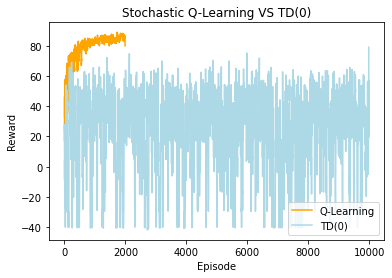

In [75]:
plt.title('Stochastic Q-Learning VS TD(0)')
plt.xlabel('Episode')
plt.ylabel('Reward')
# plt.plot(q_d_rewards,'ro', td_d_rewards, 'g*')
t = [np.mean(td_s_rewards[tr:tr+window]) for tr in range(window, len(td_s_rewards))]
q = [np.mean(q_s_rewards[tr:tr+window]) for tr in range(window, len(q_s_rewards))]
plt.plot(q,'orange',label='Q-Learning')
plt.plot( t, 'lightblue',label = 'TD(0)')
plt.legend(loc="lower right")
plt.show()